# Walmart Forecasting with XGBoost Models
By: Robert Russ

### Loading the libraries

In [7]:
# !pip3 install pandas numpy xgboost matplotlib statsmodels seaborn tqdm scikit-learn xgboost

# python 3.9.12

In [2]:
import pandas as pd
import numpy as np

from itertools import product
from multiprocessing import Pool
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
import scipy.stats as scs
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import datetime
# from dateutil.relativedelta import relativedelta
import time
import gc
import os
from tqdm import tqdm_notebook
import tqdm
import warnings
warnings.filterwarnings (action = "ignore")

# Set some options in Jupyter to display datasets.
pd.set_option ('display.max_columns', 200)
pd.set_option ('display.max_rows', 200)

# Variable to control Kaggle training.
TRAIN_OFFLINE = False

# Variable to indicate the local path.
LOCAL_DATA_FOLDER  = 'data/'
KAGGLE_DATA_FOLDER = '/kaggle/input/m5-forecasting-accuracy/'

In [3]:
import platform
print(platform.architecture())


('64bit', '')


In [4]:
# !pip3.8 install xgboost==1.6.2
# !pip3 install xgboost --no-binary xgboost -v

In [4]:
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

import xgboost as xgb

### Importing the data

In [5]:
# Function for reducing the used memory.
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[: 3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df [col] = df [col] .astype (np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df [col] = df [col] .astype (np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {: 5.2f} Mb ({: .1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Function for reading LOCAL or KAGGLE files.
def read_data(loc):
    
    # If local.
    if TRAIN_OFFLINE:

        calendar = pd.read_csv(loc+'calendar.csv')
        sell_prices = pd.read_csv(loc+'sell_prices.csv')
        sales_train_validation = pd.read_csv(loc+'sales_train_validation.csv')
        submission = pd.read_csv(loc+'sample_submission.csv')

    # If you are in the Kaggle environment.
    else:
        
        calendar = pd.read_csv(loc+'calendar.csv')
        sell_prices = pd.read_csv(loc+'sell_prices.csv')
        sales_train_validation = pd.read_csv(loc+'sales_train_validation.csv')
        submission = pd.read_csv(loc+'sample_submission.csv')

    calendar = reduce_mem_usage(calendar)
    sell_prices = reduce_mem_usage(sell_prices)
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    submission = reduce_mem_usage(submission)
        
    return calendar, sell_prices, sales_train_validation, submission

In [6]:
# Reading the data and applying memory reduction.
loc = ''
calendar, sell_prices, sales_train_validation, submission = read_data(loc)

Mem. usage decreased to  0.12 Mb ( 41.9% reduction)
Mem. usage decreased to  130.48 Mb ( 37.5% reduction)
Mem. usage decreased to  95.00 Mb ( 78.7% reduction)
Mem. usage decreased to  2.09 Mb ( 84.5% reduction)


### Feature Engineering

In [8]:
# Function to merge datasets returning only one dataframe.
def reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 30000000, merge = False):
    
    # Reshaping sales data using melt.
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print ('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_trian_validation = reduce_mem_usage(sales_train_validation)
    
    # Preparing test and validation records.
    test_rows = [row for row in submission['id'] if 'validation' in row]
    val_rows = [row for row in submission['id'] if 'evaluation' in row]
    
    test = submission[submission ['id']. isin(test_rows)]
    val = submission[submission ['id']. isin(val_rows)]
    
    # Renaming the columns.
    test.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921',
                    'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930',
                    'd_1931', 'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
                    'd_1940', 'd_1941']
    val.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949',
                   'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958',
                   'd_1959', 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967',
                   'd_1968', 'd_1969']
    
    # Getting only product data and removing duplicate records.
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]. drop_duplicates ()
    
    # Merge with the product table.
    test = test.merge(product, how = 'left', on = 'id')
    val = val.merge(product, how = 'left', on = 'id')
    
    # Reshaping test and validation data.
    test = pd.melt(test, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    val = pd.melt(val, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    # Creating a new column to define training, test and validation data.
    sales_train_validation['part'] = 'train'
    test['part'] = 'test'
    val['part'] = 'val'
    
    # Creating a single dataset with the addition of all training, validation and test records.
    data = pd.concat([sales_train_validation, test, val], axis = 0)
    
    # Removing previous datasets.
    del sales_train_validation, test, val
    
    # Selecting only a few records for training.
    data = data.loc[nrows:]
    
    # Removing validation data.
    data = data[data ['part']!= 'val']
    
    # Performing the merge with calendar and price.
    if merge:
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day', 'weekday'], inplace = True, axis = 1)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Final dataset for training has {} rows and {} columns'.format(data.shape [0], data.shape [1]))
    else:
        pass
    
    return data

# Function for handling missing values and transformation of categorical/numeric features
def transform(data):
    
    # Performing treatment on missing values for the categorical features.
    nan_features_cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features_cat:
        data[feature] .fillna('unknown', inplace = True)
    
    # Performing treatment on missing values for the sell_price feature.
    data['sell_price']. fillna(0, inplace = True)
        
    # Turning features categories into numbers to make predictions.
    encoder = preprocessing.LabelEncoder ()
    data['id_encode'] = encoder.fit_transform(data ['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
           'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

In [9]:
%%time

# Reshaping and merging datasets.
data = reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, merge = True)

# Calling up the data transformation functions.
data = transform(data)

# Viewing the final dataset header.
data.head()

# Clearing data from memory.
gc.collect()

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to  3226.27 Mb ( 0.0% reduction)
Final dataset for training has 29181090 rows and 21 columns
CPU times: user 2min 51s, sys: 2min 15s, total: 5min 7s
Wall time: 6min 11s


0

In [13]:
data.shape

(29181090, 22)

In [14]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
0,HOUSEHOLD_1_331_WI_3_validation,2326,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,4.878906,23269
1,HOUSEHOLD_1_332_WI_3_validation,2327,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,0.000000,23279
2,HOUSEHOLD_1_333_WI_3_validation,2328,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,2.970703,23289
3,HOUSEHOLD_1_334_WI_3_validation,2329,5,2,9,2,11,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,0.979980,23299
4,HOUSEHOLD_1_335_WI_3_validation,2330,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,8.968750,23309


In [15]:
# Checking the start and end date of the dataset.
print(min(data['date']), max(data['date']))

2013-10-08 2016-05-22


### Time Series in Python

- Methods and models that we can use for predictions in this dataset.
- Create LR Ridge Regression and XGBoost model.

#### Check the feature engineering and transformations.

In [16]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
0,HOUSEHOLD_1_331_WI_3_validation,2326,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,4.878906,23269
1,HOUSEHOLD_1_332_WI_3_validation,2327,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,0.000000,23279
2,HOUSEHOLD_1_333_WI_3_validation,2328,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,2.970703,23289
3,HOUSEHOLD_1_334_WI_3_validation,2329,5,2,9,2,11,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,0.979980,23299
4,HOUSEHOLD_1_335_WI_3_validation,2330,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,8.968750,23309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29181085,FOODS_3_823_WI_3_validation,1432,2,0,9,2,0,test,2016-05-22,11617,2,5,2016,30,4,2,2,0,0,0,2.980469,14329
29181086,FOODS_3_824_WI_3_validation,1433,2,0,9,2,0,test,2016-05-22,11617,2,5,2016,30,4,2,2,0,0,0,2.480469,14339
29181087,FOODS_3_825_WI_3_validation,1434,2,0,9,2,0,test,2016-05-22,11617,2,5,2016,30,4,2,2,0,0,0,3.980469,14349
29181088,FOODS_3_826_WI_3_validation,1435,2,0,9,2,0,test,2016-05-22,11617,2,5,2016,30,4,2,2,0,0,0,1.280273,14359


In [17]:
data[data['id'] == 'FOODS_3_634_WI_2_validation'].head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
29410,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,2013-10-09,11337,5,10,2013,30,4,2,2,1,1,1,3.980469,12468
59900,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2013-10-10,11337,6,10,2013,30,4,2,2,1,0,0,3.980469,12468
90390,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,2013-10-11,11337,7,10,2013,30,4,2,2,0,1,1,3.980469,12468
120880,FOODS_3_634_WI_2_validation,1246,2,0,8,2,13,train,2013-10-12,11338,1,10,2013,30,4,2,2,0,1,1,3.980469,12468
151370,FOODS_3_634_WI_2_validation,1246,2,0,8,2,10,train,2013-10-13,11338,2,10,2013,30,4,2,2,0,1,0,3.980469,12468


In [18]:
data[(data['id'] == 'FOODS_3_634_WI_2_validation') & (data['demand'] > 0) & (data['part'] == 'train')]

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
29410,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,2013-10-09,11337,5,10,2013,30,4,2,2,1,1,1,3.980469,12468
59900,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2013-10-10,11337,6,10,2013,30,4,2,2,1,0,0,3.980469,12468
90390,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,2013-10-11,11337,7,10,2013,30,4,2,2,0,1,1,3.980469,12468
120880,FOODS_3_634_WI_2_validation,1246,2,0,8,2,13,train,2013-10-12,11338,1,10,2013,30,4,2,2,0,1,1,3.980469,12468
151370,FOODS_3_634_WI_2_validation,1246,2,0,8,2,10,train,2013-10-13,11338,2,10,2013,30,4,2,2,0,1,0,3.980469,12468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28202170,FOODS_3_634_WI_2_validation,1246,2,0,8,2,2,train,2016-04-20,11612,5,4,2016,30,4,2,2,0,0,0,3.980469,12468
28232660,FOODS_3_634_WI_2_validation,1246,2,0,8,2,3,train,2016-04-21,11612,6,4,2016,30,4,2,2,0,0,0,3.980469,12468
28263150,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2016-04-22,11612,7,4,2016,30,4,2,2,0,0,0,3.980469,12468
28293640,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2016-04-23,11613,1,4,2016,30,4,2,2,0,0,0,3.980469,12468


#### Selecting Training and Validation Data

In [19]:
# Selecting only 1 item for testing: FOODS_3_634_WI_2.
df = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_3_634_WI_2_validation') & (data ['demand'] > 0) & (data['demand'] <= 15)]

# Selecting only a few columns for analysis and training.
df = df[['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]

# Transforming the date as index.
df = df.set_index('date')

# Viewing the dataset result.
df.head()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2013-10-09,8,2,0,8,2,30,4,1,3.980469
2013-10-10,5,2,0,8,2,30,4,0,3.980469
2013-10-11,8,2,0,8,2,30,4,1,3.980469
2013-10-12,13,2,0,8,2,30,4,1,3.980469
2013-10-13,10,2,0,8,2,30,4,0,3.980469


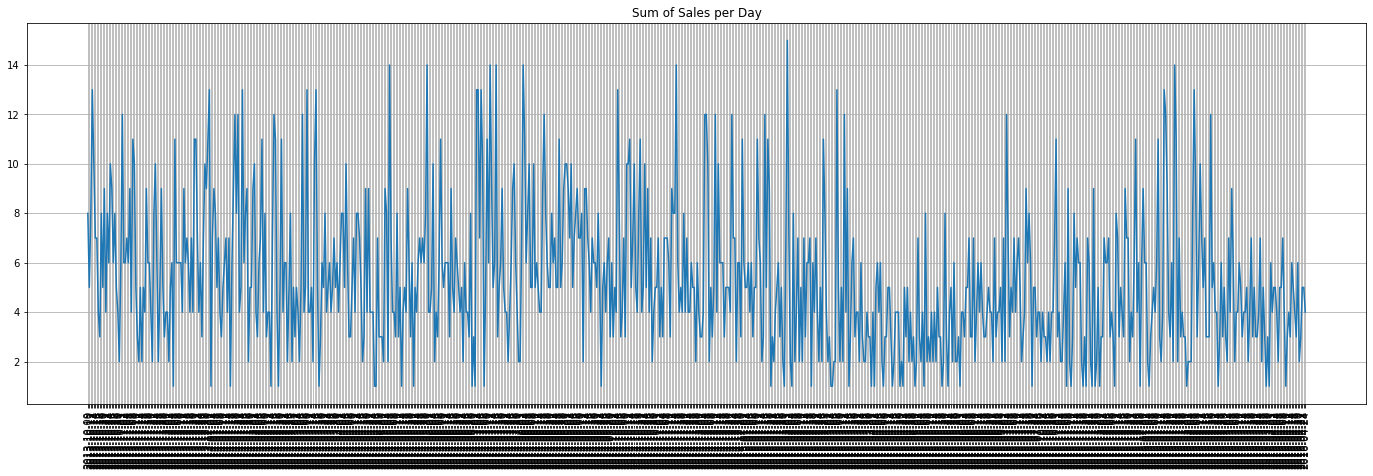

In [20]:
# Display the sum of sales per day.
plt.figure(figsize=(24, 7))
plt.plot(df['demand'])
plt.title('Sum of Sales per Day')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

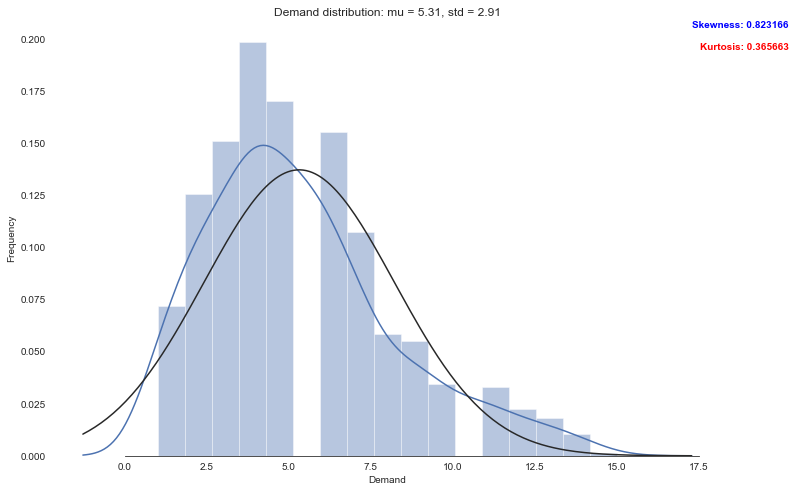

In [21]:
# Viewing distribution information for the variable "demand".
sns.set_style("white")
sns.set_color_codes(palette = 'deep')
f, ax = plt.subplots(figsize = (12, 8))

# Fit a normal distribution.
mu, std = norm.fit(df['demand'])

# Checking the frequency distribution of the variable "demand".
sns.distplot (df['demand'], color = "b", fit = stats.norm)
ax.xaxis.grid(False)
ax.set(ylabel = "Frequency")
ax.set(xlabel = "Demand")
ax.set(title = "Demand distribution: mu =% .2f, std =% .2f"% (mu, std))
sns.despine(trim = True, left = True)

# Adding Skewness and Kurtosis.
ax.text(x = 1.1, y = 1, transform = ax.transAxes, s = "Skewness:% f"% df ['demand']. skew (), \
        fontweight = 'demibold', fontsize = 10, verticalalignment = 'top', horizontalalignment = 'right', \
        backgroundcolor = 'white', color = 'blue')
ax.text(x = 1.1, y = 0.95, transform = ax.transAxes, s = "Kurtosis:% f"% df ['demand']. kurt (), \
        fontweight = 'demibold', fontsize = 10, verticalalignment = 'top', horizontalalignment = 'right', \
        backgroundcolor = 'white', color = 'red')

plt.show()

### Metrics for forecasting

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Time Series Cross Validation

Cross validation is done differently with time series data because of the time structure of the data.  I cannot just use randomization to get the data for each sample for the folds in cross validation.  Instead, we use the following ideas:  

I train a model on a small segment of the time series from the beginning to tt, made predictions for the next steps of t + nt + n and calculated an error. Next, I expand the training sample to the value t + nt + n, make predictions from t + nt + n to t + 2 ∗ nt + 2 ∗ n and continue moving the time series test window until I reach the last available observation. As a result, I have many samples nn between the initial training sample and the last observation.  The graphic illustrates cross validation with time series well.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Retrieved from: https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png

The model was off by 3.16 (RMSE), which is pretty good.  There is a lot of time investigating and preparing the data for this score.  This model is pretty unstable in production environment.  I would need to train the model often, and this makes automating the process difficult.  I will consider using Linear Regression and XGBoost machine learning model in this notebook which is more stable in a production environment.  I will need to preprocess, transform, and split the data before forecasting with these models.

### Feature Extraction

Features to extract from dataset:
- Lags of time series
- Window statistics such as max, min, average, median, variance values of a window.
- Date and time features such as special events, day of the week, month, year, holidays, etc
- Target encoding

### Time Series Lags

I will increase lags to 28 days which allow the forecast to predict 28 steps ahead and use 28 steps back.  In selecting the intial delay, I will need to find a balance in the optimal forecast quality and the forecast duration (mlcourse.ai).  

In [23]:
# Create a copy of the original dataset.
new_df = df.copy ()

# Viewing the dataset.
new_df.head ()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2013-10-09,8,2,0,8,2,30,4,1,3.980469
2013-10-10,5,2,0,8,2,30,4,0,3.980469
2013-10-11,8,2,0,8,2,30,4,1,3.980469
2013-10-12,13,2,0,8,2,30,4,1,3.980469
2013-10-13,10,2,0,8,2,30,4,0,3.980469


In [24]:
# Adding features considering the demand delay of 7 to 28 days.
for i in range (7, 29):
     new_df ["lag _ {}". format (i)] = new_df ['demand']. shift (i)

In [25]:
# Viewing the dataset result.
new_df.tail ()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price,lag _ 7,lag _ 8,lag _ 9,lag _ 10,lag _ 11,lag _ 12,lag _ 13,lag _ 14,lag _ 15,lag _ 16,lag _ 17,lag _ 18,lag _ 19,lag _ 20,lag _ 21,lag _ 22,lag _ 23,lag _ 24,lag _ 25,lag _ 26,lag _ 27,lag _ 28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-20,2,2,0,8,2,30,4,0,3.980469,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0,3.0
2016-04-21,3,2,0,8,2,30,4,0,3.980469,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0
2016-04-22,5,2,0,8,2,30,4,0,3.980469,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0
2016-04-23,5,2,0,8,2,30,4,0,3.980469,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0
2016-04-24,4,2,0,8,2,30,4,0,3.980469,4.0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0


In [26]:
# Time series cross-validation.
tscv = TimeSeriesSplit (n_splits = 5)

In [27]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test  = X.iloc[test_index:]
    y_test  = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [28]:
# Set the dependent and independent variables.
y = new_df.dropna()['demand']
X = new_df.dropna().drop(['demand'], axis=1)

In [29]:
# Split 10% for the test dataset.
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

### Linear Regression Models with Time Series

In [30]:
# Instantiating and fitting a linear regression to the time series data.
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [31]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modeled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmse(y_test, prediction)
    plt.title("RMSE: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

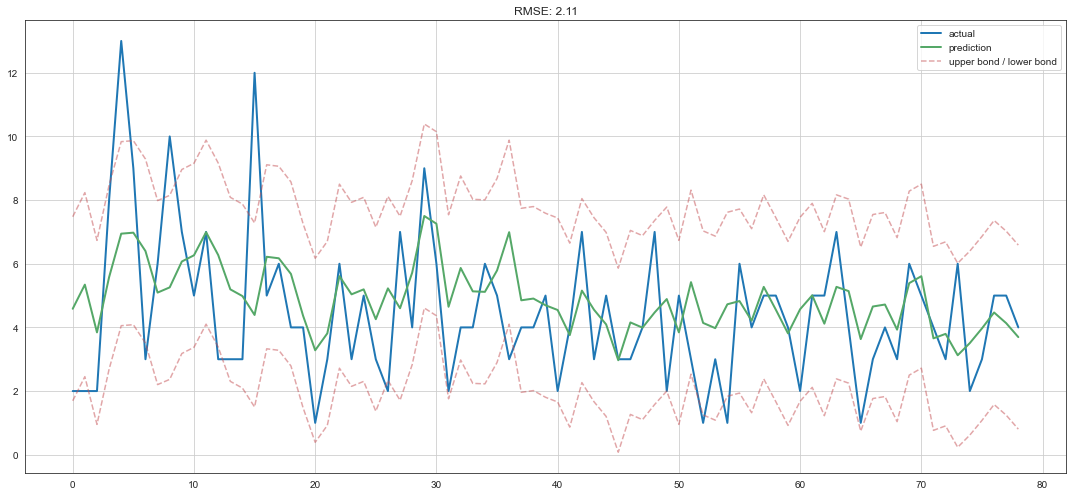

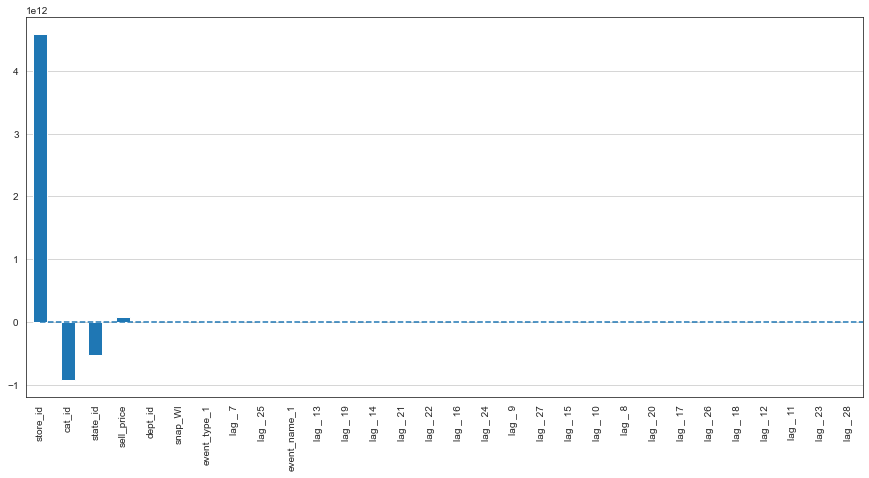

In [32]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

I can see with some simple lags that there are unnecessary features.  I will select features later and engineer some features to improve the performance of the linear regression and other XGBoost regressor.

In [33]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [34]:
new_df.sample()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price,lag _ 7,lag _ 8,lag _ 9,lag _ 10,lag _ 11,lag _ 12,lag _ 13,lag _ 14,lag _ 15,lag _ 16,lag _ 17,lag _ 18,lag _ 19,lag _ 20,lag _ 21,lag _ 22,lag _ 23,lag _ 24,lag _ 25,lag _ 26,lag _ 27,lag _ 28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-14,6,2,0,8,2,30,4,1,3.980469,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0,3.0,3.0,5.0,3.0,7.0,4.0


In [35]:
new_df['date'] = pd.to_datetime(new_df.index)
new_df['day']  = new_df['date'].dt.day

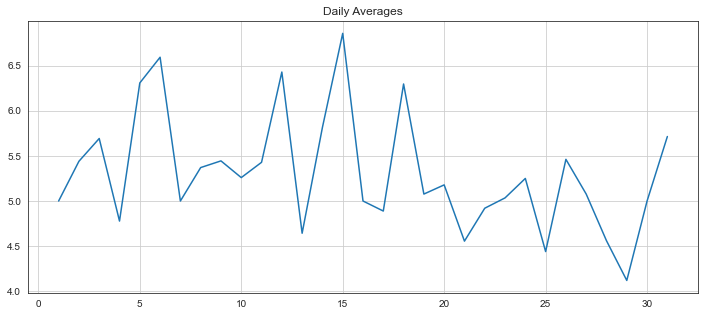

In [36]:
average_day = code_mean(new_df, 'day', "demand")
plt.figure(figsize=(12, 5))
plt.title("Daily Averages")
pd.DataFrame.from_dict(average_day, orient='index')[0].plot()
plt.grid(True);

In [37]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Copy of the initial dataset.
    new_df = df.copy()

    # lags of series
    for i in range(7, 29):
        new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

    # datetime features
    new_df.index = pd.to_datetime(new_df.index)
    new_df["day"] = new_df.index.day
    new_df["weekday"] = new_df.index.weekday
    new_df['is_weekend'] = new_df.weekday.isin([5,6])*1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(new_df.dropna())*(1-test_size))
        new_df['weekday_average'] = list(map(code_mean(new_df[:test_index], 'weekday', "demand").get, new_df['weekday']))
        new_df["day_average"] = list(map(code_mean(new_df[:test_index], 'day', "demand").get, new_df['day']))

        # frop encoded variables 
        new_df.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = new_df.dropna()['demand']
    X = new_df.dropna().drop(['demand'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

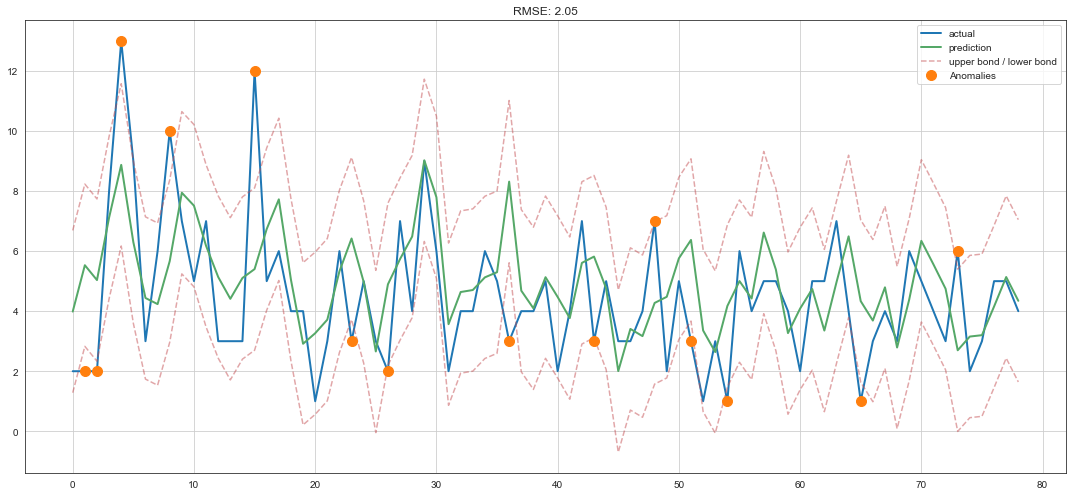

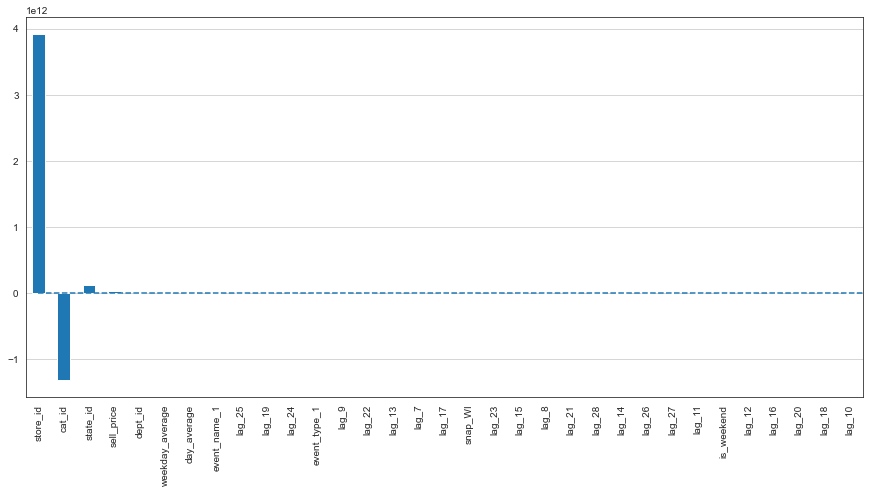

In [38]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

The RMSE increased after feature engineering and encoding.  The model is overfitting the data, so I need to use some regularization techniques for linear regression to correct the overfitting.  I will also select features to help improve the model's performance. 

In [39]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Ridge & Lasso Regression

#### Regularization & Feature Selection

Retrieved from: mlcourse.ai

Not all features are equally important - some can lead to overfitting, while others must be removed. In addition to manual inspection, regularization can be applied. Two of the most popular regression models with regularization are the Ridge and Lasso regressions. Both add some more restrictions to our loss function.

In the case of Ridge regression, these restrictions are the sum of the squares of the coefficients multiplied by the smoothing coefficient. The higher the coefficient of a feature, the greater our loss. Therefore, we will try to optimize the model, keeping the coefficients reasonably low.

As a result of this regularization of L2, we will have a higher bias and less variation, so that the model generalizes better.

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, the coefficients of unimportant features become zeros, which allows automated selection of resources. This type of regularization is called L1.

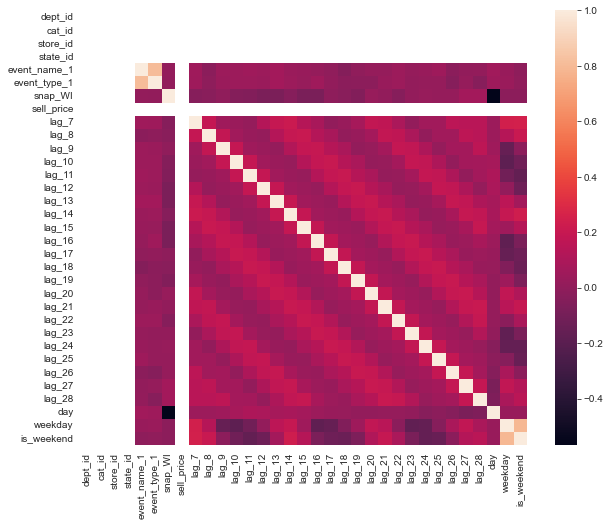

In [40]:
# Check training data for multicollinearity.
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

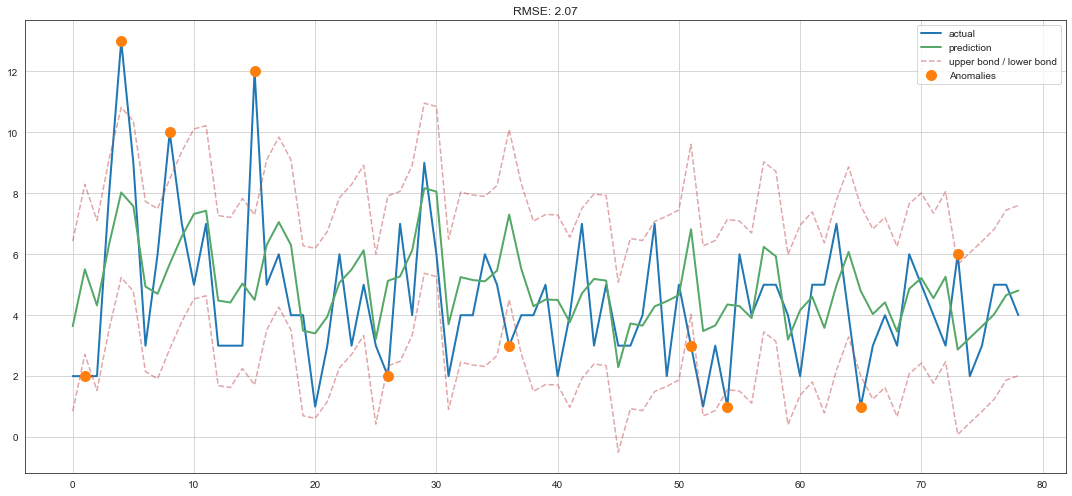

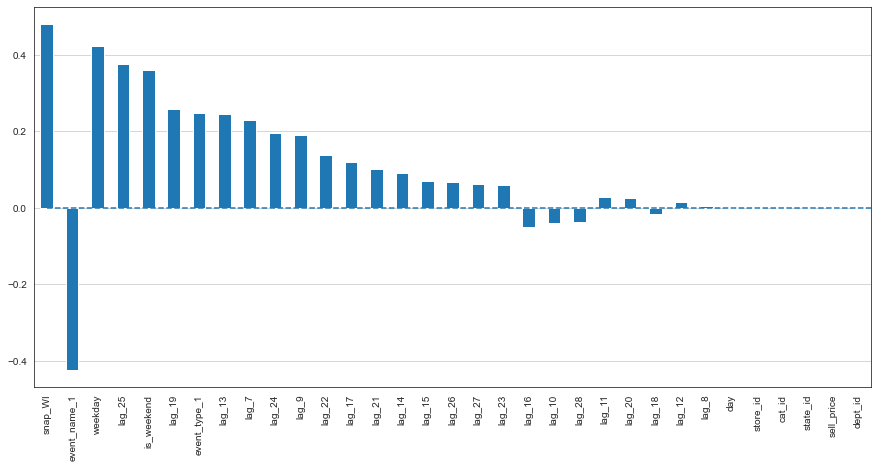

In [41]:
# Ridge Regression.
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(ridge)

I can see some of the coefficients are moving closer to zero but never reach it as their importance in the model decreases.

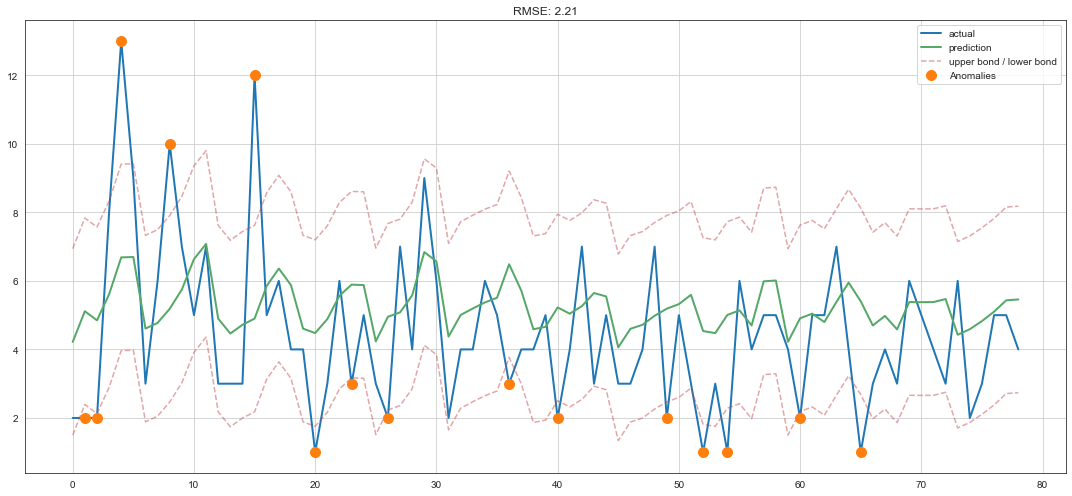

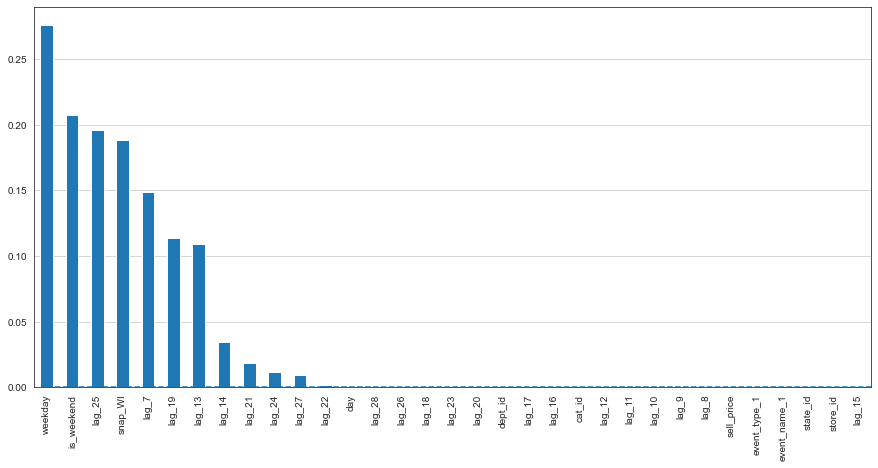

In [42]:
# Lasso Regression for feature selection.
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(lasso)

The Lasso regression removed some of the important lag features which lead to woresen the performance to a RMSE of 3.24.  I do not think I needed to use Lasso Regression due to decreasing the performance of the model.

### XGBoost Regressor

In [43]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()

xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

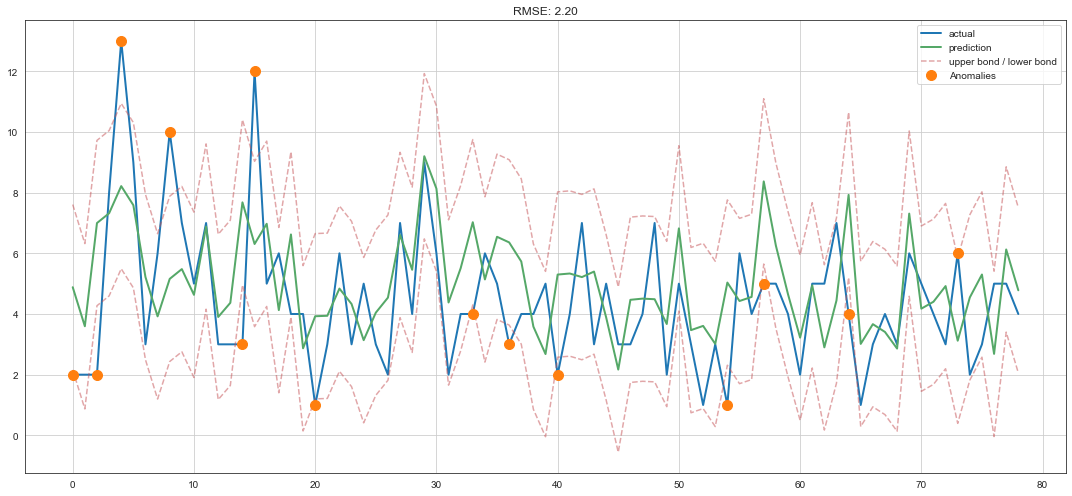

In [44]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)